# Handwritten Receipt to Structured Data Format with Qwen 2.5-VL

This notebook shows how to:

1. load the 3-B-parameter Qwen 2.5-VL-Instruct model,
2. send an image plus a natural-language request in “chat” format,
3. receive an AI-generated caption, and
4. visualise both the input image and the caption.

Runtime note: The model uses ~6 GB VRAM in float-16 mode. If you are on a GPU without enough memory, set device_map="cpu" instead of "auto".

# 1 Install necessary packages

In [ ]:
# Install PyTorch, if not installed already, skip for Colab
%pip install torch torchvision torchaudio

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Install Transformers, if not installed already, skip for Colab
%pip install transformers

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Upgrade Qwen-VL utilities
!pip install qwen-vl-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 21.1 MB/s eta 0:00:00


# 2 Imports

In [2]:
# ── Standard library ────────────────────────────────────────────
import os          # File‑system helpers (paths, env vars, etc.)
import random      # Lightweight randomness (e.g. sample prompts)
import textwrap    # Nicely format long strings for display
import io          # In‑memory byte streams (e.g. image buffers)
import requests    # Simple HTTP requests for downloading assets


In [3]:
# ── Numerical computing ─────────────────────────────────────────
import numpy as np  # Core array maths (fast, vectorised operations)


In [4]:
# ── Deep‑learning stack ─────────────────────────────────────────
import torch  # Tensor library + GPU acceleration
from transformers import (
    Qwen2_5_VLForConditionalGeneration,  # Multimodal LLM (image+text)
    AutoProcessor,                       # Paired tokenizer/feature‑extractor
)


In [5]:
# ── Imaging & visualisation ─────────────────────────────────────
from PIL import Image                    # Pillow: load/save/manipulate images
import matplotlib.pyplot as plt          # Quick plots in notebooks
import matplotlib.patches as patches     # Bounding‑box overlays, etc.

# ── Project‑specific helpers ────────────────────────────────────
from qwen_vl_utils import process_vision_info  # Post‑process Qwen outputs

# ── Notebook conveniences ──────────────────────────────────────
import IPython.display as ipd             # Inline display (images, audio, HTML)


# 3 Device & model load

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype="auto",     # automatically uses FP16 on GPU, FP32 on CPU
    device_map="auto"       # dispatches layers to the available device(s)
)
processor = AutoProcessor.from_pretrained(model_id)

print(f"Model loaded on: {model.device}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

Model loaded on: cuda:0


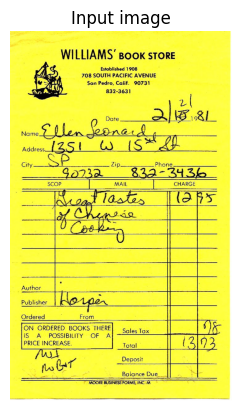

In [7]:
url = "https://penhopechest.com/wp-content/uploads/2012/04/handwritten-receipt-1981.jpg"
img = Image.open(io.BytesIO(requests.get(url, timeout=15).content)).convert("RGB")

# Display the image
plt.imshow(img)
plt.axis("off")
plt.title("Input image")
plt.show()


# 5 Build a chat-style prompt¶
## 5.1 Create a message in JSON format
Qwen VL uses the same multi-turn message format as Qwen-2.5-Chat:

```

msgs = [
    { "role": "user",
      "content": [
          {"type": "image", "image": img},
          {"type": "text",  "text": "Summarize all the details of the receipt. Output the result in JSON format."}
      ],
    }
]

```


The processor turns these messages into plain text (with special tokens) and extracts the visual tensors so the model receives both modalities.

In [9]:
msgs = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text",  "text": "Summarize all the details of the receipt. Output the result in JSON format."}
        ],
    }
]

## 5.2 Apply Chat Template
Every chat model ships with a pattern. The above JSON format needs to be converted to this template and this is done using apply_chat_template. It performs three tasks.

1. Reads the model’s chat template: Qwen 2.5VL has a chat template that looks like <|im_start|>{role}\n{content}<|im_end|>.
2. Fills in the template with the msgs list. It loops over each message, swaps in the role (user, assistant, etc.) and the content (text plus special markers), and concatenates the result into one long string.
3. Adds the “assistant starts talking now” marker (add_generation_prompt=True). At the end it appends <|im_start|>assistant

We have also instructed it to NOT tokenize the text because we are going to use the processor to process text and images together, and tokenization will be performed in that step.

In [10]:
# Build the full textual prompt that Qwen-VL expects
# --------------------------------------------------
# • msgs : list of message dicts (roles + content, including <image> markers)
# • tokenize=False : return a plain string—not token IDs—so we can
#                    combine it with image tensors in the next processor() call
# • add_generation_prompt=True : appends the “assistant is about to speak” marker
#                                (e.g. "<|im_start|>assistant\n"), which tells the
#                                model where its reply should begin.
text_prompt = processor.apply_chat_template(
    msgs,
    tokenize=False,
    add_generation_prompt=True
)

# For sanity-checking: print the raw prompt string that will be fed to the model
print(text_prompt)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Summarize all th edetails of the receipt. Output the result in JSON format.<|im_end|>
<|im_start|>assistant



## 5.3 Extract image & video inputs from msg
In the previous step we converted our message msg from JSON format to the chat template the model understands.

Now, we need to extract images and videos from msg using process_vision_info utility. It performs the following tasks

1. Walks through every message,
1. Finds all "image" / "video" entries,
3. Applies the Qwen-VL visual pre-processing to ensure each image is a PIL.Image (or each video is a list / tensor of frames).
4. Returns two parallel lists/tensors
>- image_inputs → batched image tensors (or [] if none)
>- video_inputs → batched video tensors (or [] if none)

In [11]:
# Extract vision-modalities from msgs and convert them to model-ready tensors
# --------------------------------------------------------------------------
# • msgs : the same chat-style list you fed to apply_chat_template.
#          Each dict can include items like {"type": "image", "image": img}
#          or {"type": "video", "video": video_clip}.
# • process_vision_info : project utility that
#       1) walks through every message,
#       2) finds all `"image"` / `"video"` entries,
#       3) applies the Qwen-VL visual pre-processing to ensure each
#          image is a PIL.Image (or each video is a list / tensor of frames).
#       4) returns two parallel lists/tensors:
#            – `image_inputs`  → batched image tensors (or [] if none)
#            – `video_inputs`  → batched video tensors (or [] if none)
#   These outputs plug straight into the `processor(...)` call that follows,
#   ensuring the vision data is aligned with the text prompt.
image_inputs, video_inputs = process_vision_info(msgs)

# 6 Generate the caption

## 6.1 Run inference

In [19]:
# ── Pack text + vision into model-ready tensors ──────────────────────────────
inputs = processor(
    text=[text_prompt],      # 1-element batch containing the chat prompt string
    images=image_inputs,     # list of raw PIL images (pre-processed inside processor)
    videos=video_inputs,     # list of raw video clips (if any)
    padding=True,            # pad sequences so text/vision tokens line up in a batch
    return_tensors="pt",     # return a dict of PyTorch tensors (input_ids, pixel_values, …)
).to(model.device)           # move every tensor—text & vision—to the model’s GPU/CPU

# ── Run inference (no gradients, pure generation) ───────────────────────────
with torch.no_grad():                     # disable autograd to save memory
    generated_ids = model.generate(       # autoregressive decoding
        **inputs,                         # unpack dict into generate(...)
        max_new_tokens=1024                 # cap the response at 1024 tokens
    )
print(inputs.input_ids[0])
print(generated_ids)

tensor([151644,   8948,    198,  ..., 151644,  77091,    198], device='cuda:0')
tensor([[151644,   8948,    198,  ...,    532,  73594, 151645]],
       device='cuda:0')


## 6.2 Decode output

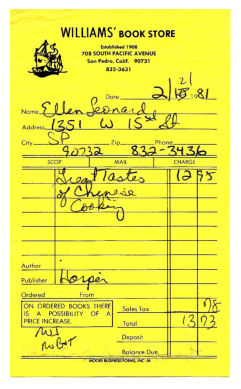

```json {   "store": "WILLIAMS' BOOK STORE",   "address": "708 SOUTH PACIFIC AVENUE San Pedro, Calif. 90731",   "phone": "832-3631",   "date": "2/15/1981",   "customer": {     "name": "Ellen Leonard",     "address": "1351 W 15th St",     "city": "SP",     "zip": "90732",     "phone": "832-3436"   },   "items": [     {       "title": "Great Tastes of Chinese Cooking",       "price": "12.95",       "tax": "0.08",       "total": "13.03"     }   ],   "notes": "ON ORDERED BOOKS THERE IS A POSSIBILITY OF A PRICE INCREASE.",   "footer": "MOORE BUSINESS FORMS, INC-M" } ```


In [20]:
# Extract the newly generated tokens (skip the prompt length)
caption = processor.batch_decode(
    generated_ids[:, inputs.input_ids.shape[-1]:],
    skip_special_tokens=True
)[0]

# Display the image
plt.imshow(img)
plt.axis("off")
plt.show()

# Print caption
width = 800
wrapped_caption = textwrap.fill(caption, width)
print(wrapped_caption)